In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import config
os.chdir(config.LOOP_CATALOG_DIR)
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 400)

## Apply QC Flags - FC Loops

In [155]:
org = "mm10"
organism = "Mouse"
merge = "merged"

date1 = "10.16.2024"
date2 = "10_16_24"

#### Prepare HiChIP Pre-Processing Stats

In [156]:
hicpro_all = pd.read_csv("results/tables/update_{d1}/tsv/{o}.{m}_hicpro.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")
if merge == "merged" and org == "hg38":
    hicpro_all = pd.concat([hicpro_all, pd.read_csv("results/tables/update_{d1}/tsv/hg38.mega-merged_hicpro.{d2}.tsv".format(d1 = date1, d2 = date2), sep = "\t")])

In [157]:
hicpro_all["mean_mapping_percentage"] = hicpro_all.apply(lambda x : np.mean([x["mapped_R1"] / x["total_R1"], x["mapped_R2"] / x["total_R2"]]), axis = 1)
hicpro_all["percent_validpairs"] = hicpro_all.apply(lambda x : x["Valid_interaction_pairs"] / x["Reported_pairs"], axis = 1)
#hicpro_all["percent_invalid_pairs"] = hicpro_all.apply(lambda x : (x["Dangling_end_pairs"] + x["Religation_pairs"] + x["Self_Cycle_pairs"] + x["Single-end_pairs"] + x["Filtered_pairs"] + x["Dumped_pairs"]) / x["Reported_pairs"], axis = 1)
hicpro_all["percent_duplicate"] = hicpro_all.apply(lambda x : 1 - (x["valid_interaction_rmdup"] / x["valid_interaction"]), axis = 1)
hicpro_all["cis_trans_ratio"] = hicpro_all.apply(lambda x : x["cis_interaction"] / x["trans_interaction"], axis = 1)
hicpro_all["percent_cis"] = hicpro_all.apply(lambda x : x["cis_interaction"] / (x["trans_interaction"] + x["cis_interaction"]), axis = 1)
hicpro_all["precent_cis_long_range"] = hicpro_all.apply(lambda x : x["cis_longRange"] / x["cis_interaction"], axis = 1)

In [158]:
hicpro_all = hicpro_all[["std_sample_name", "Total_pairs_processed", "valid_interaction_rmdup", "mean_mapping_percentage", "percent_validpairs", "percent_duplicate", "percent_cis", "precent_cis_long_range"]]
hicpro_all.columns = ["Sample Name", "num_reads", "num_vp", "mean_mapping_percentage", "percent_validpairs", "percent_duplicate", "percent_cis", "precent_cis_long_range"]

In [159]:
len(hicpro_all)

109

#### Prepare ChIP-seq Pre-Processing Stats

In [160]:
meta = "results/samplesheets/post-hicpro/chipseq_samples_08_02_2024.tsv"
tag = pd.read_csv(meta, sep="\t", header=None)
tag.columns = ["Sample Name ChIP-seq", "Paired", "Tagmentation"]
tag["Tagmentation"] = tag.apply(lambda x : "No Tagmentation" if x["Tagmentation"] == "No Tag" else "Tagmentation", axis = 1)
tag["Paired"] = tag.apply(lambda x : "Paired-End" if x["Paired"] == "paired-end" else "Single-End", axis = 1)

In [161]:
sample_mapper = pd.concat([pd.read_csv("results/samplesheets/chipseq/chipseq.chipline.batch1.txt", sep="\t", header=None), pd.read_csv("results/samplesheets/chipseq/chipseq.chipline.batch2.txt", sep="\t", header=None)])
sample_mapper = sample_mapper.loc[sample_mapper[3] != "t2t"].sort_values(by=0).reset_index(drop=True)
sample_mapper = sample_mapper[[0, 9]]
sample_mapper = sample_mapper.assign(GSM=sample_mapper[9].str.split(',')).explode('GSM').reset_index(drop=True)
sample_mapper['GSM'] = sample_mapper['GSM'].str.strip()
sample_mapper = sample_mapper[[0, 'GSM']]
sample_mapper.columns = ["Sample Name ChIP-seq", "GSM"]

In [162]:
meta1 = config.LOOP_CATALOG_DIR + "results/stats/chipseq_num_reads/chipseq_num_reads.final.tsv"
reads = pd.read_csv(meta1)
reads["LibraryName"] = reads['LibraryName'].astype(str)
reads = reads.loc[~reads["LibraryName"].str.contains("Input")] # remove input chipseq
reads = reads[["SampleName", "spots"]]
reads = reads.groupby(by="SampleName").aggregate({"spots" : 'sum'})
reads["GSM"]  = reads.index
reads = reads[["GSM", "spots"]].reset_index(drop=True)
reads["GSM"] = reads.apply(lambda x : "GSM7336681" if x["GSM"] == "L2-3" else x["GSM"], axis = 1)
reads["GSM"] = reads.apply(lambda x : "GSM7336682" if x["GSM"] == "KO" else x["GSM"], axis = 1)

new = ['GSM5513456', '48151841']
new = pd.DataFrame(columns=reads.columns, data=[new])
reads = pd.concat([reads, new], axis=0)
reads = reads.sort_values(by="GSM").reset_index(drop=True)

In [163]:
r = sample_mapper.merge(reads, on="GSM").groupby("Sample Name ChIP-seq").aggregate({"GSM" : lambda x: list(x), 'spots' : 'sum'})
r["Sample Name ChIP-seq"] = r.index
r = r[["Sample Name ChIP-seq", "GSM", "spots"]].reset_index(drop=True)

r["Sample Name ChIP-seq"] = r.apply(lambda x : "JN-DSRCT1-shEWSWT1.GSE212977.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "JN-DSRCT1.shEWSWT1.GSE212977.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)
r["Sample Name ChIP-seq"] = r.apply(lambda x : "JN-DSRCT1-shGFP.GSE212977.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "JN-DSRCT1.shGFP.GSE212977.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)
r["Sample Name ChIP-seq"] = r.apply(lambda x : "L3-6pl.GSE213378.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "L3.6pl.GSE213378.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)

## USES NUMBER OF MAPPABLE READS (unmapped reads are excluded)
factor = 1.046 # median factor, all chip-seq datasets
# get unique mapped reads, multiply by factor to estimate number of reads - have to do this because FASTQs were deleted
pieqtl = {"CD4N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1" : str(int(128770801 * factor)), 
          "CD8N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1" : str(int(132789316 * factor)), 
          "Mono_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1" : str(int(195365713 * factor)), 
          "NB_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1" : str(int(193369327 * factor)), 
          "NCM_merged_donors.phs001703v4p1.Homo_Sapiens.H3K27ac.b1" : str(int(121515283 * factor)), 
          "NK_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1" : str(int(97462331 * factor))}

for p in list(pieqtl.keys()):
    new = [p, "None",pieqtl[p]]
    new = pd.DataFrame(columns=r.columns, data=[new])
    r = pd.concat([r, new], axis=0)

r = r.sort_values(by="Sample Name ChIP-seq").reset_index(drop=True)
r = r.drop(columns="GSM")
r.columns = ["Sample Name ChIP-seq", "num_reads_chipseq"]

In [164]:
files = glob.glob("results/qc/chipseq_qc/*/out_stats_09.16.24_new.txt")
stats = []
for file in files:
    data = []
    data.append(file.strip().split("/")[3])
    with open(file) as f:
        for line in f:
            if ":" in line:
                data.append(float(line.strip().split(": ")[1]))
    stats.append(data)
chipseq_all = pd.DataFrame(stats)
chipseq_all.columns = ["Sample Name ChIP-seq", "unique_mapped_reads", "unique_genome_pos", "nrf", "m1", "m2", "pbc1", "pbc2", "mapped_reads_narrowpeak", "frip", "nsc", "rsc"]
chipseq_all = chipseq_all.sort_values(by = "Sample Name ChIP-seq").reset_index(drop = True)

# perform merges to complete metadata
chipseq_all = tag.merge(chipseq_all, on = "Sample Name ChIP-seq").sort_values(by = "Sample Name ChIP-seq").reset_index(drop=True)

chipseq_all["Sample Name ChIP-seq"] = chipseq_all.apply(lambda x : "JN-DSRCT1-shEWSWT1.GSE212977.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "JN-DSRCT1.shEWSWT1.GSE212977.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)
chipseq_all["Sample Name ChIP-seq"] = chipseq_all.apply(lambda x : "JN-DSRCT1-shGFP.GSE212977.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "JN-DSRCT1.shGFP.GSE212977.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)
chipseq_all["Sample Name ChIP-seq"] = chipseq_all.apply(lambda x : "L3-6pl.GSE213378.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "L3.6pl.GSE213378.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)

chipseq_all = r.merge(chipseq_all, on = "Sample Name ChIP-seq").sort_values(by = "Sample Name ChIP-seq").reset_index(drop=True)

# if RSC is negative
chipseq_all["rsc"] = chipseq_all.apply(lambda x : 0 if x["rsc"] < 0 else x["rsc"], axis = 1)

chipseq_all["num_reads_chipseq"] = chipseq_all['num_reads_chipseq'].astype(int)

In [165]:
chipseq_all.sort_values(by="pbc1", ascending=True)

,Sample Name ChIP-seq,num_reads_chipseq,Paired,Tagmentation,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc
50,Erythroid_0hr.GSE142003.Mus_Musculus.YY1.b1,89682380,Single-End,No Tagmentation,65906442.0,3336109.0,0.050,377342.0,143399.0,0.113,2.631,79671.0,0.001,1.083586,0.390474
51,Erythroid_1hr.GSE142003.Mus_Musculus.YY1.b1,79412420,Single-End,No Tagmentation,62493378.0,4665618.0,0.074,596340.0,322119.0,0.127,1.851,242788.0,0.003,1.089811,0.333617
29,CD8N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,138897624,Single-End,Tagmentation,132789316.0,30309465.0,0.228,5995258.0,4867897.0,0.197,1.231,9486792.0,0.071,1.068764,0.949359
114,Mono_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,204352535,Single-End,Tagmentation,195365713.0,40278320.0,0.206,8079763.0,7218021.0,0.200,1.119,16208031.0,0.082,1.079012,1.126482
169,VCAP-Veh.GSE157105.Homo_Sapiens.H3K27ac.b1,44098824,Paired-End,No Tagmentation,36322596.0,7390408.0,0.203,2007688.0,1115970.0,0.271,1.799,4870177.0,0.134,1.231109,0.875113
168,VCAP-DHT-2hr.GSE157105.Homo_Sapiens.H3K27ac.b1,48128757,Paired-End,No Tagmentation,36821541.0,5037329.0,0.136,1446768.0,608307.0,0.287,2.378,2784122.0,0.075,1.277477,0.721359
167,VCAP-DHT-24hr.GSE157105.Homo_Sapiens.H3K27ac.b1,39440266,Paired-End,No Tagmentation,31032859.0,6403453.0,0.206,1900778.0,996918.0,0.296,1.906,4023031.0,0.129,1.215724,0.808248
132,NSD2-High-NTKO.GSE131651.Homo_Sapiens.CTCF.b1,96702732,Paired-End,Tagmentation,93581642.0,34820773.0,0.372,14905830.0,9328390.0,0.428,1.597,13831692.0,0.147,1.372815,1.033830
134,Nalm6.GSE115494.Homo_Sapiens.H3K27ac.b1,96160526,Single-End,No Tagmentation,87939452.0,38727395.0,0.440,18277961.0,10168247.0,0.471,1.797,20887876.0,0.237,1.103645,1.754455
133,NSD2-Low-TKO.GSE131651.Homo_Sapiens.CTCF.b1,93260788,Paired-End,Tagmentation,90550450.0,33612691.0,0.371,16925044.0,8233919.0,0.503,2.055,14344995.0,0.158,1.336108,1.043621


In [166]:
chipseq_all.describe()

,num_reads_chipseq,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc
count,1.890000e+02,1.890000e+02,1.890000e+02,189.000000,1.890000e+02,1.890000e+02,189.000000,189.000000,1.890000e+02,189.000000,189.000000,189.000000
mean,6.708847e+07,6.177845e+07,3.848832e+07,0.686270,3.037497e+07,5.129123e+06,0.795370,10.200958,1.816498e+07,0.308614,1.182938,3.357412
std,8.213990e+07,7.081774e+07,2.877767e+07,0.161861,2.086573e+07,5.403996e+06,0.162537,10.456131,2.698859e+07,0.154568,0.229774,7.509603
min,1.036728e+07,6.058180e+05,5.599490e+05,0.050000,3.773420e+05,5.564000e+03,0.113000,1.119000,7.967100e+04,0.001000,1.005513,0.000000
25%,3.544032e+07,3.361110e+07,2.355284e+07,0.633000,1.776074e+07,1.475231e+06,0.717000,4.011000,6.588769e+06,0.201000,1.058064,1.284033
50%,5.072758e+07,4.804415e+07,3.298334e+07,0.713000,2.613227e+07,4.266225e+06,0.830000,6.332000,1.489763e+07,0.301000,1.107731,1.686874
75%,7.739794e+07,7.061824e+07,4.786992e+07,0.801000,3.898826e+07,6.845145e+06,0.907000,12.139000,2.080660e+07,0.421000,1.215724,2.484035
max,1.024425e+09,8.835590e+08,2.850670e+08,0.924000,1.605652e+08,5.606042e+07,0.989000,99.630000,3.472516e+08,0.664000,2.387096,64.530140


In [70]:
col = "frip"

In [15]:
print("0.00:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0), 3)))
print("0.05:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.05), 3)))
print("0.10:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.10), 3)))
print("0.15:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.15), 3)))
print("0.20:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.20), 3)))
print("0.25:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.25), 3)))
print("0.50:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.50), 3)))
print("0.75:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.75), 3)))
print("0.90:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.90), 3)))
print("0.95:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 0.95), 3)))
print("1.00:", "{:,}".format(round(np.nanquantile(chipseq_all[[col]], 1), 3)))

0.00: 0.001
0.05: 0.06
0.10: 0.091
0.15: 0.133
0.20: 0.156
0.25: 0.201
0.50: 0.301
0.75: 0.421
0.90: 0.511
0.95: 0.539
1.00: 0.664


In [ ]:
thres_cs = {"num_reads_chipseq" : (15000000, 20000000), 
         "nrf" : (0.50, 0.80), 
         "pbc1" : (0.50, 0.80), 
         "pbc2" : (1, 3), 
         "nsc" : (1.01, 1.1), 
         "rsc" : (0.8, 1)}
thres_peaks = {"num_peaks" : (1000, 5000),
         "frip" : (0.01, 0.15)}

data = chipseq_all[col]

if col == "num_reads_chipseq":
    data = data[data < 1000000000]

sns.displot(data, bins = 20)
plt.axvline(x=thres_peaks[col][0], color='red', linestyle='--', linewidth=2)
plt.axvline(x=thres_peaks[col][1], color='red', linestyle='--', linewidth=2)

#### Prepare Peaks and Loops Stats

In [167]:
l = pd.read_csv("results/tables/update_{d1}/tsv/{o}.{m}_loops.chipseq.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")
p = pd.read_csv("results/tables/update_{d1}/tsv/{o}.peaks.chipseq.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")

if merge == "merged" and org == "hg38":
    l = pd.concat([l, pd.read_csv("results/tables/update_{d1}/tsv/hg38.mega-merged_loops.chipseq.{d2}.tsv".format(o = org, m = merge, d1 = date1, d2 = date2), sep = "\t")])
    
l.columns = ["Sample Name", "Peaks", "Stringent 5kb", "Loose 5kb", "Stringent 10kb", "Loose 10kb", "Stringent 25kb", "Loose 25kb"]
p.columns = ["Sample Name ChIP-seq", "Number of Peaks", "Average Peak Size (bp)"]
p["Sample Name ChIP-seq"] = p.apply(lambda x : "JN-DSRCT1-shEWSWT1.GSE212977.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "JN-DSRCT1.shEWSWT1.GSE212977.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)
p["Sample Name ChIP-seq"] = p.apply(lambda x : "JN-DSRCT1-shGFP.GSE212977.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "JN-DSRCT1.shGFP.GSE212977.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)
p["Sample Name ChIP-seq"] = p.apply(lambda x : "L3-6pl.GSE213378.Homo_Sapiens.H3K27ac.b1" if x["Sample Name ChIP-seq"] == "L3.6pl.GSE213378.Homo_Sapiens.H3K27ac.b1" else x["Sample Name ChIP-seq"], axis = 1)

In [168]:
print(len(p))
print(len(l))

39
30


#### Merge All Stats Together

In [169]:
mapper = pd.read_csv("results/samplesheets/post-hicpro/2024.08.15.16.32.peaks_files_chipseq.all_batches.for-qc.samplesheet.without_header.tsv", sep = "\t", header=None)
mapper[3] = mapper.apply(lambda x : x[2].strip().split("/")[x[2].strip().split("/").index("chipline_v2") + 1], axis = 1)
mapper = mapper[[0,3]]
mapper.columns = ["Sample Name", "Sample Name ChIP-seq"]

if merge =="merged":
    mapper["Sample Name"] = mapper.apply(lambda x : x["Sample Name"][:-2] + "biorep_merged" if "All-Donors" not in x["Sample Name"] else x["Sample Name"], axis = 1)
    mapper = mapper.drop_duplicates("Sample Name")
    
hicpro_all = hicpro_all.merge(mapper, on="Sample Name")

In [170]:
f = hicpro_all.merge(chipseq_all, on="Sample Name ChIP-seq", how="left")
f = f.merge(p, on="Sample Name ChIP-seq", how="left")
f = f.merge(l, on="Sample Name", how="left")

In [171]:
len(f)

30

In [172]:
f = f.dropna()

In [173]:
len(f)

30

#### General Helper Functions

In [174]:
def calculate_upper_bounds(f, stats):
    upper_bounds = []
    for stat in stats:
        if max(list(f[stat])) <= 1:
            upper_bounds.append(1)
        else:
            data = np.array(f[stat])
            iqr = np.subtract(*np.percentile(data, [75, 25]))
            upper_bounds.append(np.percentile(data, 75) + (1.5 * iqr))
    return upper_bounds

def calculate_weights(t1, t2, i1, i2, i3, i4, upper_bound):
    weights = {"Poor" : (i2 - i1) / t1, 
               "Warning" : (i3 - i2) / (t2 - t1), 
               "Good" : (i4 - i3) / (upper_bound - t2)}   
    return weights
      
def calculate_score(stat, t1, t2, i1, i2, i3, i4, upper_bound):
    weights = calculate_weights(t1, t2, i1, i2, i3, i4, upper_bound)
    if stat < t1:
        return weights["Poor"] * stat
    elif stat >= t1 and stat < t2:
        return weights["Warning"] * (stat - t1) + i2
    else:
        if stat > upper_bound:
            return 10
        return weights["Good"] * (stat - t2) + i3

In [175]:
def qc_score(stats, intervals, upper_bounds, feature):    
    if feature == "preprocess":
        thres = {"num_reads" : (30000000, 50000000), 
                 "num_vp" : (3000000, 10000000), 
                 "prop_mapping" : (0.70, 0.80), 
                 "prop_vp" : (0.40, 0.60), 
                 "prop_dup" : (0.85, 0.50), 
                 "prop_cis" : (0.40, 0.60), 
                 "prop_cis_lr" : (0.30, 0.40)}
    elif feature == "chipseq":
        thres = {"num_reads_chipseq" : (15000000, 20000000), 
                 "nrf" : (0.20, 0.50), 
                 "pbc1" : (0.20, 0.50), 
                 "pbc2" : (1, 3), 
                 "nsc" : (1.01, 1.05), 
                 "rsc" : (0.8, 1)}
    elif feature == "peaks":
        thres = {"num_peaks" : (1000, 5000),
                 "frip" : (0.01, 0.1)}
    elif feature == "loops":
        thres = {"num_loops_s5" : (100, 1000),
                 "num_loops_l5" : (100, 1000),
                 "num_loops_s10" : (100, 1000),
                 "num_loops_l10" : (100, 1000),
                 "num_loops_s25" : (100, 1000),
                 "num_loops_l25" : (100, 1000)}
    
    scores = [None] * len(stats)

    for i in range(0, len(stats)):
        if feature == "loops":
            if i % 2 == 0: # 0, 2, 4 (stringent)
                if stats[i] > stats[i+1]:
                    scores[i] = 0
                    continue
            else: # 1, 3, 5 (loose)
                if stats[i-1] > stats[i]:
                    scores[i] = 0
                    continue
                    
        thres1 = thres[list(thres.keys())[i]][0]
        thres2 = thres[list(thres.keys())[i]][1]
        
        if thres1 < thres2:
            scores[i] = calculate_score(stats[i], thres1, thres2, intervals[0], intervals[1], intervals[2], intervals[3], upper_bounds[i])
        else:
            scores[i] = intervals[3] - calculate_score(stats[i], thres1, thres2, intervals[0], intervals[1], intervals[2], intervals[3], upper_bounds[i]) 
    return pd.Series(scores)

def qc_flag(scores, intervals):
    scores = np.array(scores)
    quadratic = False
    if quadratic:
        scores = scores ** 2
        score_agg = sum(scores) / len(scores)
        if score_agg < (intervals[1] * intervals[3]):
            flag = "Poor"
        elif score_agg >= (intervals[1] * intervals[3]) and score_agg < (intervals[2] * intervals[3]):
            flag = "Warning"
        else:
            flag = "Good"
    else:
        score_agg = np.mean(scores)
        if score_agg < (intervals[1]):
            flag = "Poor"
        elif score_agg >= (intervals[1]) and score_agg < (intervals[2]):
            flag = "Warning"
        else:
            flag = "Good"
    return pd.Series((score_agg, flag))

def final_flag(flag1, flag2):
    if flag1 == "Poor" and flag2 == "Poor":
        return "Poor"
    elif flag1 == "Warning" and flag2 == "Poor":
        return "Poor"
    elif flag1 == "Good" and flag2 == "Poor":
        return "Poor"
    elif flag1 == "Poor" and flag2 == "Warning":
        return "Poor"
    elif flag1 == "Warning" and flag2 == "Warning":
        return "Warning"
    elif flag1 == "Good" and flag2 == "Warning":
        return "Warning"
    elif flag1 == "Poor" and flag2 == "Good":
        return "Poor"
    elif flag1 == "Warning" and flag2 == "Good":
        return "Warning"
    elif flag1 == "Good" and flag2 == "Good":
        return "Good"

def final_flag3(flag1, flag2, flag3):
    intermediate_flag = final_flag(flag1, flag2)
    return final_flag(intermediate_flag, flag3)

#### General Variables

In [176]:
intervals = [0, 6, 8, 10]

#### Apply Flags - Pre-Processing

In [177]:
upper_bounds = calculate_upper_bounds(f, ["num_reads", "num_vp", "mean_mapping_percentage", "percent_validpairs", "percent_duplicate", "percent_cis", "precent_cis_long_range"])
upper_bounds

[1340584302.25, 792472408.125, 1, 1, 1, 1, 1]

In [178]:
f[["score_num_reads", "score_num_vp", "score_prop_mapping", "score_prop_vp", "score_prop_dups", "score_prop_cis", "score_prop_cislr"]] = f.apply(lambda x : qc_score([x["num_reads"], x["num_vp"], x["mean_mapping_percentage"], x["percent_validpairs"], x["percent_duplicate"], x["percent_cis"], x["precent_cis_long_range"]], intervals, upper_bounds, "preprocess"), axis = 1)
f[["PREPROCESSING_SCORE", "PREPROCESSING_FLAG"]] = f.apply(lambda x : qc_flag([x["score_num_reads"], x["score_num_vp"],x["score_prop_mapping"], x["score_prop_vp"], x["score_prop_dups"], x["score_prop_cis"], x["score_prop_cislr"]], intervals), axis = 1)

In [179]:
f.describe()

,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,num_reads_chipseq,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,score_num_reads,score_num_vp,score_prop_mapping,score_prop_vp,score_prop_dups,score_prop_cis,score_prop_cislr,PREPROCESSING_SCORE
count,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,3.000000e+01,3.000000e+01,30.000000,30.000000,3.000000e+01,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,6.056009e+08,2.269254e+08,0.908222,0.810410,0.231198,0.788993,0.750681,1.186456e+08,1.018220e+08,5.295084e+07,0.631500,4.076639e+07,6.697716e+06,0.787833,11.309267,2.545260e+07,0.20630,1.091217,4.893253,139877.166667,664.287166,139877.166667,18820.600000,48564.833333,64872.000000,145024.733333,130544.600000,253209.833333,8.861007,8.464080,9.035526,8.722924,8.368016,8.932926,8.886366,8.752978
std,2.619334e+08,1.489626e+08,0.070347,0.233309,0.202565,0.091761,0.179121,1.837592e+08,1.559921e+08,5.469639e+07,0.220962,3.557089e+07,1.053344e+07,0.223392,9.604316,6.253276e+07,0.14552,0.073294,12.989671,144370.262523,236.914167,144370.262523,28847.484322,60243.689634,82704.168697,146265.425923,122140.338324,181819.825893,0.405915,0.608728,0.816087,2.279577,1.429871,0.497386,1.662446,0.736725
min,1.538441e+08,4.731163e+06,0.742700,0.042337,0.024370,0.527753,0.093924,1.285791e+07,1.175016e+07,3.336109e+06,0.050000,3.773420e+05,1.433990e+05,0.113000,1.851000,7.967100e+04,0.00100,1.005577,0.000000,6155.000000,336.181683,6155.000000,7.000000,7.000000,14.000000,14.000000,50.000000,103.000000,8.160926,6.494618,6.854006,0.635053,5.075546,7.277533,1.878473,6.279226
25%,4.350980e+08,8.713777e+07,0.894904,0.825590,0.093228,0.750820,0.717900,5.195885e+07,4.446960e+07,2.300311e+07,0.559750,2.027903e+07,1.413660e+06,0.699750,3.575250,3.719170e+06,0.08675,1.035448,1.238548,59972.750000,450.547381,59972.750000,1342.500000,3664.250000,9411.250000,32085.250000,46228.500000,91663.000000,8.596781,8.197164,8.949045,9.127949,7.283398,8.754100,9.059667,8.473427
50%,6.250152e+08,2.227053e+08,0.943149,0.895535,0.136645,0.816503,0.788137,7.162936e+07,6.652891e+07,4.446619e+07,0.711500,3.480543e+07,2.662640e+06,0.883000,9.000500,7.833536e+06,0.19450,1.073959,1.395592,116598.000000,701.232333,116598.000000,7716.000000,20477.000000,32774.500000,109787.500000,98562.000000,234034.500000,8.891093,8.543675,9.431486,9.477676,9.035449,9.082514,9.293791,9.097652
75%,7.972925e+08,3.692716e+08,0.954061,0.913884,0.384852,0.834488,0.844587,1.175529e+08,1.132118e+08,6.402210e+07,0.787750,5.293087e+07,7.792474e+06,0.911500,12.389500,2.767342e+07,0.33550,1.133369,1.835638,166192.750000,809.524936,166192.750000,20086.000000,70750.500000,80581.000000,206772.750000,164898.750000,342353.250000,9.158068,8.918299,9.540615,9.569421,9.341923,9.172438,9.481956,9.194403
max,1.171548e+09,5.043628e+08,0.968206,0.972771,0.697631,0.946181,0.912941,1.024425e+09,8.835590e+08,2.850670e+08,0.858000,1.605652e+08,5.606042e+07,0.973000,38.504000,3.472516e+08,0.51100,1.253019,64.530140,771880.000000,1122.272929,771880.000000,96606.000000,206988.000000,257454.000000,465894.000000,541875.000000,675939.000000,9.738046,9.263592,9.682059,9.863854,9.827976,9.730907,9.709803,9.306978


In [180]:
f["PREPROCESSING_FLAG"].value_counts()

PREPROCESSING_FLAG
Good       28
Warning     2
Name: count, dtype: int64

In [ ]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("num_reads", "score_num_reads"),
    ("num_vp", "score_num_vp"),
    ("mean_mapping_percentage", "score_prop_mapping"),
    ("percent_validpairs", "score_prop_vp"),
    ("percent_duplicate", "score_prop_dups"),
    ("percent_cis", "score_prop_cis"),
    ("precent_cis_long_range", "score_prop_cislr")
]

column_labels = [
    ("Number of Reads", "Number of Reads Score"),
    ("Number of Valid Pairs", "Number of Valid Pairs Score"),
    ("Mean Mapping % (R1/R2)", "Mean Mapping % (R1/R2) Score"),
    ("% Valid Pairs", "% Valid Pairs Score"),
    ("% Duplicate Pairs", "% Duplicate Pairs Score"),
    ("% Cis Pairs", "% Cis Pairs Score"),
    ("% Cis Long-Range Pairs", "% Cis Long-Range Pairs Score")
]

fill_values = [
    [(0, 30000000), (30000000, 50000000), (50000000, max(list(f["num_reads"])))],
    [(0, 3000000), (3000000, 10000000), (10000000, max(list(f["num_vp"])))],
    [(0, 0.70), (0.70, 0.80), (0.80, 1)],
    [(0, 0.40), (0.40, 0.60), (0.60, 1)],
    [(0.85, 1), (0.45, 0.85), (0.0, 0.45)],
    [(0, 0.40), (0.40, 0.60), (0.60, 1)],
    [(0, 0.30), (0.30, 0.40), (0.40, 1)],
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 15.0 / 7.0 * len(columns_pairs)))

for i, (col1, col2) in enumerate(columns_pairs):
    sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    y1_max = axes[i, 0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[i, 1])
    y2_max = axes[i, 1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[i, 1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[i, 0].set_xlabel(labels[0])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].set_xlabel(labels[1])
    axes[i, 1].set_ylabel('Count')
    
    if i == 0:
        axes[i, 0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[i, 1].legend(loc='upper left', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="ticks")
fig = sns.histplot(f["PREPROCESSING_SCORE"], element="step", alpha=0.4, color = "maroon")
y_max = fig.get_ylim()[1] * 1.02

plt.fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
plt.fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
plt.fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

fig.set_ylim(0, y_max)
fig.legend(loc='upper left', facecolor = "white", framealpha = 1)
fig.set_xlabel("Pre-Processing Aggregate Score")

#### Applying Flags - ChIP-seq Pre-Processing

In [181]:
upper_bounds = calculate_upper_bounds(f, ["num_reads_chipseq", "nrf", "pbc1", "pbc2", "nsc", "rsc"])
upper_bounds

[215943944.125, 1, 1, 25.610875, 1.2802509999999998, 2.731272375]

In [182]:
f[["score_num_reads_chipseq", "score_nrf", "score_pbc1", "score_pbc2", "score_nsc", "score_rsc"]] = f.apply(lambda x : qc_score([x["num_reads_chipseq"], x["nrf"], x["pbc1"], x["pbc2"], x["nsc"], x["rsc"]], intervals, upper_bounds, "chipseq"), axis = 1)
f[["CHIPSEQ_PREPROCESSING_SCORE", "CHIPSEQ_PREPROCESSING_FLAG"]] = f.apply(lambda x : qc_flag([x["score_num_reads_chipseq"], x["score_nrf"],x["score_pbc1"], x["score_pbc2"], x["score_nsc"], x["score_rsc"]], intervals), axis = 1)

In [183]:
f.describe()

,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,num_reads_chipseq,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,score_num_reads,score_num_vp,score_prop_mapping,score_prop_vp,score_prop_dups,score_prop_cis,score_prop_cislr,PREPROCESSING_SCORE,score_num_reads_chipseq,score_nrf,score_pbc1,score_pbc2,score_nsc,score_rsc,CHIPSEQ_PREPROCESSING_SCORE
count,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,3.000000e+01,3.000000e+01,30.000000,30.000000,3.000000e+01,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,6.056009e+08,2.269254e+08,0.908222,0.810410,0.231198,0.788993,0.750681,1.186456e+08,1.018220e+08,5.295084e+07,0.631500,4.076639e+07,6.697716e+06,0.787833,11.309267,2.545260e+07,0.20630,1.091217,4.893253,139877.166667,664.287166,139877.166667,18820.600000,48564.833333,64872.000000,145024.733333,130544.600000,253209.833333,8.861007,8.464080,9.035526,8.722924,8.368016,8.932926,8.886366,8.752978,8.381300,8.175867,8.959333,8.586757,7.958399,8.016929,8.346431
std,2.619334e+08,1.489626e+08,0.070347,0.233309,0.202565,0.091761,0.179121,1.837592e+08,1.559921e+08,5.469639e+07,0.220962,3.557089e+07,1.053344e+07,0.223392,9.604316,6.253276e+07,0.14552,0.073294,12.989671,144370.262523,236.914167,144370.262523,28847.484322,60243.689634,82704.168697,146265.425923,122140.338324,181819.825893,0.405915,0.608728,0.816087,2.279577,1.429871,0.497386,1.662446,0.736725,1.232392,1.876471,1.548066,0.746350,1.097719,2.290445,0.897691
min,1.538441e+08,4.731163e+06,0.742700,0.042337,0.024370,0.527753,0.093924,1.285791e+07,1.175016e+07,3.336109e+06,0.050000,3.773420e+05,1.433990e+05,0.113000,1.851000,7.967100e+04,0.00100,1.005577,0.000000,6155.000000,336.181683,6155.000000,7.000000,7.000000,14.000000,14.000000,50.000000,103.000000,8.160926,6.494618,6.854006,0.635053,5.075546,7.277533,1.878473,6.279226,5.143163,1.500000,3.390000,6.851000,5.973725,0.000000,5.389226
25%,4.350980e+08,8.713777e+07,0.894904,0.825590,0.093228,0.750820,0.717900,5.195885e+07,4.446960e+07,2.300311e+07,0.559750,2.027903e+07,1.413660e+06,0.699750,3.575250,3.719170e+06,0.08675,1.035448,1.238548,59972.750000,450.547381,59972.750000,1342.500000,3664.250000,9411.250000,32085.250000,46228.500000,91663.000000,8.596781,8.197164,8.949045,9.127949,7.283398,8.754100,9.059667,8.473427,8.326204,8.239000,8.799000,8.050883,7.272425,8.275575,8.374989
50%,6.250152e+08,2.227053e+08,0.943149,0.895535,0.136645,0.816503,0.788137,7.162936e+07,6.652891e+07,4.446619e+07,0.711500,3.480543e+07,2.662640e+06,0.883000,9.000500,7.833536e+06,0.19450,1.073959,1.395592,116598.000000,701.232333,116598.000000,7716.000000,20477.000000,32774.500000,109787.500000,98562.000000,234034.500000,8.891093,8.543675,9.431486,9.477676,9.035449,9.082514,9.293791,9.097652,8.526981,8.846000,9.532000,8.530762,8.208112,8.456996,8.552085
75%,7.972925e+08,3.692716e+08,0.954061,0.913884,0.384852,0.834488,0.844587,1.175529e+08,1.132118e+08,6.402210e+07,0.787750,5.293087e+07,7.792474e+06,0.911500,12.389500,2.767342e+07,0.33550,1.133369,1.835638,166192.750000,809.524936,166192.750000,20086.000000,70750.500000,80581.000000,206772.750000,164898.750000,342353.250000,9.158068,8.918299,9.540615,9.569421,9.341923,9.172438,9.481956,9.194403,8.995722,9.151000,9.646000,8.830530,8.724162,8.965345,8.772566
max,1.171548e+09,5.043628e+08,0.968206,0.972771,0.697631,0.946181,0.912941,1.024425e+09,8.835590e+08,2.850670e+08,0.858000,1.605652e+08,5.606042e+07,0.973000,38.504000,3.472516e+08,0.51100,1.253019,64.530140,771880.000000,112

In [184]:
f["CHIPSEQ_PREPROCESSING_FLAG"].value_counts()

CHIPSEQ_PREPROCESSING_FLAG
Good       27
Poor        2
Warning     1
Name: count, dtype: int64

In [ ]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("num_reads_chipseq", "score_num_reads_chipseq"),
    ("nrf", "score_nrf"),
    ("pbc1", "score_pbc1"),
    ("pbc2", "score_pbc2"),
    ("nsc", "score_nsc"),
    ("rsc", "score_rsc")
]

column_labels = [
    ("Number of Reads", "Number of Reads Score"),
    ("NRF", "NRF Score"),
    ("PBC1", "PBC1 Score"),
    ("PBC2", "PBC2 Score"),
    ("NSC", "NSC Score"),
    ("RSC", "RSC Score")
]

fill_values = [
    [(0, 15000000), (15000000, 20000000), (20000000, max(list(f["num_reads_chipseq"])))],
    [(0, 0.20), (0.20, 0.50), (0.50, 1)],
    [(0, 0.20), (0.20, 0.50), (0.50, 1)],
    [(0, 1), (1, 3), (3, max(list(f["pbc2"])))],
    [(1, 1.01), (1.01, 1.05), (1.05, max(list(f["nsc"])))],
    [(0, 0.8), (0.80, 1), (1, max(list(f["rsc"])))]
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 15.0 / 7.0 * len(columns_pairs)))

for i, (col1, col2) in enumerate(columns_pairs):
    sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    y1_max = axes[i, 0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[i, 1])
    y2_max = axes[i, 1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[i, 1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[i, 0].set_xlabel(labels[0])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].set_xlabel(labels[1])
    axes[i, 1].set_ylabel('Count')
    
    if i == 0:
        axes[i, 0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[i, 1].legend(loc='upper left', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

Text(0.5, 0, 'ChIP-seq Pre-Processing Aggregate Score')

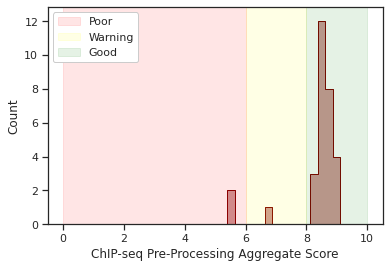

In [1040]:
sns.set_theme(style="ticks")
fig = sns.histplot(f["CHIPSEQ_PREPROCESSING_SCORE"], element="step", alpha=0.4, color = "maroon")
y_max = fig.get_ylim()[1] * 1.02

plt.fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
plt.fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
plt.fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

fig.set_ylim(0, y_max)
fig.legend(loc='upper left', facecolor = "white", framealpha = 1)
fig.set_xlabel("ChIP-seq Pre-Processing Aggregate Score")

#### Applying Flags - Peaks

In [185]:
upper_bounds = calculate_upper_bounds(f, ["Number of Peaks", "frip"])
upper_bounds

[325522.75, 1]

In [186]:
f[["score_num_peaks"]] = f.apply(lambda x : qc_score([x["Number of Peaks"]], intervals, upper_bounds, "peaks"), axis = 1)
f[["PEAKS_SCORE", "PEAKS_FLAG"]] = f.apply(lambda x : qc_flag([x["score_num_peaks"]], intervals), axis = 1)

In [187]:
f["PEAKS_AGG_FLAG"] = f.apply(lambda x : final_flag(x["CHIPSEQ_PREPROCESSING_FLAG"], x["PEAKS_FLAG"]), axis = 1)

In [188]:
f.describe()

,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,num_reads_chipseq,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,score_num_reads,score_num_vp,score_prop_mapping,score_prop_vp,score_prop_dups,score_prop_cis,score_prop_cislr,PREPROCESSING_SCORE,score_num_reads_chipseq,score_nrf,score_pbc1,score_pbc2,score_nsc,score_rsc,CHIPSEQ_PREPROCESSING_SCORE,score_num_peaks,PEAKS_SCORE
count,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,3.000000e+01,3.000000e+01,30.000000,30.000000,3.000000e+01,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,6.056009e+08,2.269254e+08,0.908222,0.810410,0.231198,0.788993,0.750681,1.186456e+08,1.018220e+08,5.295084e+07,0.631500,4.076639e+07,6.697716e+06,0.787833,11.309267,2.545260e+07,0.20630,1.091217,4.893253,139877.166667,664.287166,139877.166667,18820.600000,48564.833333,64872.000000,145024.733333,130544.600000,253209.833333,8.861007,8.464080,9.035526,8.722924,8.368016,8.932926,8.886366,8.752978,8.381300,8.175867,8.959333,8.586757,7.958399,8.016929,8.346431,8.731269,8.731269
std,2.619334e+08,1.489626e+08,0.070347,0.233309,0.202565,0.091761,0.179121,1.837592e+08,1.559921e+08,5.469639e+07,0.220962,3.557089e+07,1.053344e+07,0.223392,9.604316,6.253276e+07,0.14552,0.073294,12.989671,144370.262523,236.914167,144370.262523,28847.484322,60243.689634,82704.168697,146265.425923,122140.338324,181819.825893,0.405915,0.608728,0.816087,2.279577,1.429871,0.497386,1.662446,0.736725,1.232392,1.876471,1.548066,0.746350,1.097719,2.290445,0.897691,0.507429,0.507429
min,1.538441e+08,4.731163e+06,0.742700,0.042337,0.024370,0.527753,0.093924,1.285791e+07,1.175016e+07,3.336109e+06,0.050000,3.773420e+05,1.433990e+05,0.113000,1.851000,7.967100e+04,0.00100,1.005577,0.000000,6155.000000,336.181683,6155.000000,7.000000,7.000000,14.000000,14.000000,50.000000,103.000000,8.160926,6.494618,6.854006,0.635053,5.075546,7.277533,1.878473,6.279226,5.143163,1.500000,3.390000,6.851000,5.973725,0.000000,5.389226,8.007207,8.007207
25%,4.350980e+08,8.713777e+07,0.894904,0.825590,0.093228,0.750820,0.717900,5.195885e+07,4.446960e+07,2.300311e+07,0.559750,2.027903e+07,1.413660e+06,0.699750,3.575250,3.719170e+06,0.08675,1.035448,1.238548,59972.750000,450.547381,59972.750000,1342.500000,3664.250000,9411.250000,32085.250000,46228.500000,91663.000000,8.596781,8.197164,8.949045,9.127949,7.283398,8.754100,9.059667,8.473427,8.326204,8.239000,8.799000,8.050883,7.272425,8.275575,8.374989,8.343019,8.343019
50%,6.250152e+08,2.227053e+08,0.943149,0.895535,0.136645,0.816503,0.788137,7.162936e+07,6.652891e+07,4.446619e+07,0.711500,3.480543e+07,2.662640e+06,0.883000,9.000500,7.833536e+06,0.19450,1.073959,1.395592,116598.000000,701.232333,116598.000000,7716.000000,20477.000000,32774.500000,109787.500000,98562.000000,234034.500000,8.891093,8.543675,9.431486,9.477676,9.035449,9.082514,9.293791,9.097652,8.526981,8.846000,9.532000,8.530762,8.208112,8.456996,8.552085,8.696350,8.696350
75%,7.972925e+08,3.692716e+08,0.954061,0.913884,0.384852,0.834488,0.844587,1.175529e+08,1.132118e+08,6.402210e+07,0.787750,5.293087e+07,7.792474e+06,0.911500,12.389500,2.767342e+07,0.33550,1.133369,1.835638,166192.750000,809.524936,166192.750000,20086.000000,70750.500000,80581.000000,206772.750000,164898.750000,342353.250000,9.158068,8.918299,9.540615,9.569421,9.341923,9.172438,9.481956,9.194403,8.995722,9.151000,9.646000,8.830530,8.724162,8.965345,8.772566,9.005812,9.005812
max,1.171548e+09,5.043628e+08,0.968206,0.972771,0.697631,0.946181,0.9

In [189]:
f["PEAKS_AGG_FLAG"].value_counts()

PEAKS_AGG_FLAG
Good       27
Poor        2
Warning     1
Name: count, dtype: int64

In [ ]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("Number of Peaks", "score_num_peaks")
]

column_labels = [
    ("Number of Peaks", "Number of Peaks Score")
]

fill_values = [
    [(0, 1000), (1000, 5000), (5000, max(list(f["Number of Peaks"])))]
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 4.8))

for i, (col1, col2) in enumerate(columns_pairs):
    sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[0])
    y1_max = axes[0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[1])
    y2_max = axes[1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[0].set_ylim(0, y_max)
    axes[1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[0].set_xlabel(labels[0])
    axes[0].set_ylabel('Count')
    axes[1].set_xlabel(labels[1])
    axes[1].set_ylabel('Count')
    
    if i == 0:
        axes[0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[1].legend(loc='upper left', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

#### Applying Flags - Loops

In [191]:
upper_bounds = calculate_upper_bounds(f, ["Stringent 5kb", "Loose 5kb", "Stringent 10kb", "Loose 10kb", "Stringent 25kb", "Loose 25kb"])
upper_bounds

[48201.25, 171379.875, 187335.625, 468804.0, 342904.125, 718388.625]

In [192]:
f[["score_s5", "score_l5", "score_s10", "score_l10", "score_s25", "score_l25"]] = f.apply(lambda x : qc_score([x["Stringent 5kb"], x["Loose 5kb"], x["Stringent 10kb"], x["Loose 10kb"], x["Stringent 25kb"], x["Loose 25kb"]], intervals, upper_bounds, "loops"), axis = 1)
f[["LOOPS_SCORE_S5", "LOOPS_FLAG_S5"]] = f.apply(lambda x : qc_flag([x["score_s5"]], intervals), axis = 1)
f[["LOOPS_SCORE_L5", "LOOPS_FLAG_L5"]] = f.apply(lambda x : qc_flag([x["score_l5"]], intervals), axis = 1)
f[["LOOPS_SCORE_S10", "LOOPS_FLAG_S10"]] = f.apply(lambda x : qc_flag([x["score_s10"]], intervals), axis = 1)
f[["LOOPS_SCORE_L10", "LOOPS_FLAG_L10"]] = f.apply(lambda x : qc_flag([x["score_l10"]], intervals), axis = 1)
f[["LOOPS_SCORE_S25", "LOOPS_FLAG_S25"]] = f.apply(lambda x : qc_flag([x["score_s25"]], intervals), axis = 1)
f[["LOOPS_SCORE_L25", "LOOPS_FLAG_L25"]] = f.apply(lambda x : qc_flag([x["score_l25"]], intervals), axis = 1)

In [193]:
f["LOOPS_AGG_FLAG_S5"] = f.apply(lambda x : final_flag3(x["PREPROCESSING_FLAG"], x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_S5"]), axis = 1)
f["LOOPS_AGG_FLAG_L5"] = f.apply(lambda x : final_flag3(x["PREPROCESSING_FLAG"], x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_L5"]), axis = 1)
f["LOOPS_AGG_FLAG_S10"] = f.apply(lambda x : final_flag3(x["PREPROCESSING_FLAG"], x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_S10"]), axis = 1)
f["LOOPS_AGG_FLAG_L10"] = f.apply(lambda x : final_flag3(x["PREPROCESSING_FLAG"], x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_L10"]), axis = 1)
f["LOOPS_AGG_FLAG_S25"] = f.apply(lambda x : final_flag3(x["PREPROCESSING_FLAG"], x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_S25"]), axis = 1)
f["LOOPS_AGG_FLAG_L25"] = f.apply(lambda x : final_flag3(x["PREPROCESSING_FLAG"], x["PEAKS_AGG_FLAG"], x["LOOPS_FLAG_L25"]), axis = 1)

In [194]:
f

,Sample Name,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,Sample Name ChIP-seq,num_reads_chipseq,Paired,Tagmentation,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,score_num_reads,score_num_vp,score_prop_mapping,score_prop_vp,score_prop_dups,score_prop_cis,score_prop_cislr,PREPROCESSING_SCORE,PREPROCESSING_FLAG,score_num_reads_chipseq,score_nrf,score_pbc1,score_pbc2,score_nsc,score_rsc,CHIPSEQ_PREPROCESSING_SCORE,CHIPSEQ_PREPROCESSING_FLAG,score_num_peaks,PEAKS_SCORE,PEAKS_FLAG,PEAKS_AGG_FLAG,score_s5,score_l5,score_s10,score_l10,score_s25,score_l25,LOOPS_SCORE_S5,LOOPS_FLAG_S5,LOOPS_SCORE_L5,LOOPS_FLAG_L5,LOOPS_SCORE_S10,LOOPS_FLAG_S10,LOOPS_SCORE_L10,LOOPS_FLAG_L10,LOOPS_SCORE_S25,LOOPS_FLAG_S25,LOOPS_SCORE_L25,LOOPS_FLAG_L25,LOOPS_AGG_FLAG_S5,LOOPS_AGG_FLAG_L5,LOOPS_AGG_FLAG_S10,LOOPS_AGG_FLAG_L10,LOOPS_AGG_FLAG_S25,LOOPS_AGG_FLAG_L25
0,AML12_shCtrl.GSE141113.Mus_Musculus.H3K9me3.biorep_merged,443947549,56929456,0.797676,0.881254,0.667873,0.797287,0.830080,AML12_shCtrl.GSE141104.Mus_Musculus.H3K9me3.b1,60227974,Paired-End,No Tagmentation,51037507.0,20175453.0,0.395,17877663.0,1964373.0,0.886,9.100,8213501.0,0.160,1.042628,36.569040,144388,820.821516,144388,79,150,3076,6962,52155,87953,8.610495,8.119952,7.953529,9.406272,5.285600,8.986436,9.433601,8.256555,Good,8.410607,7.300000,9.544,8.539563,7.631400,10.000000,8.570928,Good,8.869754,8.869754,Good,Good,4.740000,6.111111,8.022282,8.025489,8.299236,8.242415,4.740000,Poor,6.111111,Warning,8.022282,Good,8.025489,Good,8.299236,Good,8.242415,Good,Poor,Warning,Good,Good,Good,Good
1,AML12_shSafb.GSE141113.Mus_Musculus.H3K9me3.biorep_merged,476004497,70317128,0.792118,0.908127,0.631400,0.744703,0.871823,AML12_shSafb.GSE141104.Mus_Musculus.H3K9me3.b1,62891192,Paired-End,No Tagmentation,53456059.0,22487832.0,0.420,19889611.0,2241596.0,0.884,8.872,8040092.0,0.150,1.034792,64.530140,145594,775.635198,145594,110,242,4595,9665,59370,102133,8.660173,8.154171,7.842355,9.540636,5.543057,8.723515,9.572742,8.290950,Good,8.437790,7.466667,9.536,8.519396,7.239600,10.000000,8.533242,Good,8.877279,8.877279,Good,Good,6.022222,6.315556,8.038586,8.037045,8.341441,8.281948,6.022222,Warning,6.315556,Warning,8.038586,Good,8.037045,Good,8.341441,Good,8.281948,Good,Warning,Warning,Good,Good,Good,Good
2,BL6_CD4_CD8.GSE141847.Mus_Musculus.H3K27ac.biorep_merged,1024425195,504362791,0.965138,0.912980,0.084009,0.611936,0.907673,BL6_CD4_CD8.GSE141847.Mus_Musculus.H3K27ac.b1,1024425195,Paired-End,No Tagmentation,883558999.0,285066983.0,0.322,148035870.0,56060421.0,0.519,2.640,347251645.0,0.393,1.064332,0.000000,771880,349.529273,771880,28610,54845,257454,386452,541875,675939,9.510053,9.263592,9.651384,9.564902,9.406995,8.059679,9.692243,9.306978,Good,10.000000,6.813333,8.076,7.640000,8.124490,0.000000,6.775637,Warning,10.000000,10.000000,Good,Warning,9.169884,8.632058,10.000000,9.647921,10.000000,9.881655,9.169884,Good,8.632058,Good,10.000000,Good,9.647921,Good,10.000000,Good,9.881655,Good,Warning,Warning,Warning,Warning,Warning,Warning
3,BL6_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.biorep_merged,1171547761,398841403,0.942102,0.813396,0.113476,0.690105,0.863307,BL6_CD4_CD8.GSE141847.Mus_Musculus.SMC1A.b1,105454441,Paired-End,No Tagmentation,98403232.0,68735482.0,0.698,59130921.0,6642549.0,0.860,8.901,22574051.0,0.229,1.111970,1.593049,134931,616.007278,134931,18115,38211,106309,229803,200424,451651,9.738046,8.993879,9.421023,9.066978,9.198995,8.450526,9.544358,9.201972,Good,8.872234,8.792000,9.440,8.521961,8.538282,8.685102,8.808263,Good,8.810744,8.810744,Good,Good,8.725193,8.436800,9.130315,8.978200,9.166549,9.256365,8.725193,Good,8.436800,Good,9.130315,Good,8.978200,Good,9.166549,Good,9.256365,Good,Good,Good,Good,Good,Good,Good
4,BMDC-CTCF_cKO-LPS.GSE185883.Mus_Musculus.H3K27ac.bio

In [195]:
f["LOOPS_AGG_FLAG_S5"].value_counts()

LOOPS_AGG_FLAG_S5
Good       23
Warning     4
Poor        3
Name: count, dtype: int64

In [196]:
f["LOOPS_AGG_FLAG_L5"].value_counts()

LOOPS_AGG_FLAG_L5
Good       25
Warning     3
Poor        2
Name: count, dtype: int64

In [197]:
f["LOOPS_AGG_FLAG_S10"].value_counts()

LOOPS_AGG_FLAG_S10
Good       27
Poor        2
Warning     1
Name: count, dtype: int64

In [198]:
f["LOOPS_AGG_FLAG_L10"].value_counts()

LOOPS_AGG_FLAG_L10
Good       27
Poor        2
Warning     1
Name: count, dtype: int64

In [199]:
f["LOOPS_AGG_FLAG_S25"].value_counts()

LOOPS_AGG_FLAG_S25
Good       27
Poor        2
Warning     1
Name: count, dtype: int64

In [200]:
f["LOOPS_AGG_FLAG_L25"].value_counts()

LOOPS_AGG_FLAG_L25
Good       27
Poor        2
Warning     1
Name: count, dtype: int64

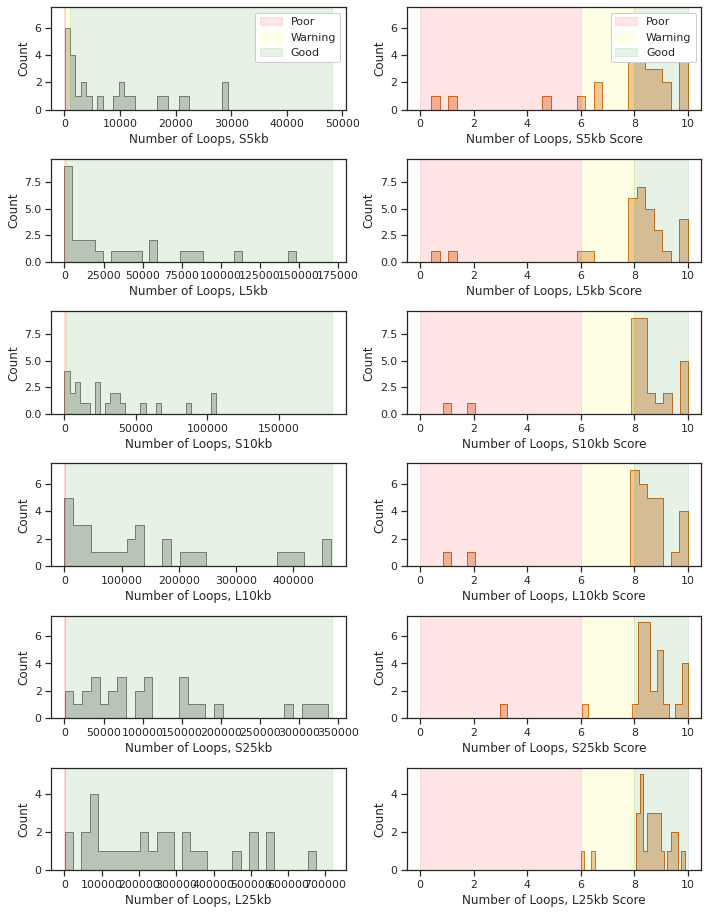

In [1057]:
sns.set_theme(style="ticks")

columns_pairs = [
    ("Stringent 5kb", "score_s5"),
    ("Loose 5kb", "score_l5"),
    ("Stringent 10kb", "score_s10"),
    ("Loose 10kb", "score_l10"),
    ("Stringent 25kb", "score_s25"),
    ("Loose 25kb", "score_l25")
]

column_labels = [
    ("Number of Loops, S5kb", "Number of Loops, S5kb Score"),
    ("Number of Loops, L5kb", "Number of Loops, L5kb Score"),
    ("Number of Loops, S10kb", "Number of Loops, S10kb Score"),
    ("Number of Loops, L10kb", "Number of Loops, L10kb Score"),
    ("Number of Loops, S25kb", "Number of Loops, S25kb Score"),
    ("Number of Loops, L25kb", "Number of Loops, L25kb Score")
]

fill_values = [
    [(0, 100), (100, 1000), (1000, upper_bounds[0])],
    [(0, 100), (100, 1000), (1000, upper_bounds[1])],
    [(0, 100), (100, 1000), (1000, upper_bounds[2])],
    [(0, 100), (100, 1000), (1000, upper_bounds[3])],
    [(0, 100), (100, 1000), (1000, upper_bounds[4])],
    [(0, 100), (100, 1000), (1000, upper_bounds[5])]
]

fig, axes = plt.subplots(nrows=len(columns_pairs), ncols=2, figsize=(10.0, 15.0 / 7.0 * len(columns_pairs)))

for i, (col1, col2) in enumerate(columns_pairs):
    #sns.histplot(f[col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    sns.histplot(f.loc[f[col1] < upper_bounds[i]][col1], alpha=0.4, bins=30, element="step", color="gray", ax=axes[i, 0])
    y1_max = axes[i, 0].get_ylim()[1]
    
    sns.histplot(np.array(f[col2]), alpha=0.4, color="chocolate", bins=30, element="step", ax=axes[i, 1])
    y2_max = axes[i, 1].get_ylim()[1]

    y_max = max(y1_max, y2_max) * 1.02
    
    fill = fill_values[i]
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[0][0], x2=fill[0][1], color='red', alpha=0.1, label='Poor')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[1][0], x2=fill[1][1], color='yellow', alpha=0.1, label='Warning')
    axes[i, 0].fill_betweenx(y=[0, y_max], x1=fill[2][0], x2=fill[2][1], color='green', alpha=0.1, label='Good')

    axes[i, 1].fill_betweenx(y=[0, y_max], x1=0, x2=6, color='red', alpha=0.1, label='Poor')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=6, x2=8, color='yellow', alpha=0.1, label='Warning')
    axes[i, 1].fill_betweenx(y=[0, y_max], x1=8, x2=10, color='green', alpha=0.1, label='Good')

    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)
    
    labels = column_labels[i]
    axes[i, 0].set_xlabel(labels[0])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].set_xlabel(labels[1])
    axes[i, 1].set_ylabel('Count')
    
    if i == 0:
        axes[i, 0].legend(loc='upper right', facecolor = "white", framealpha = 1)
        axes[i, 1].legend(loc='upper right', facecolor = "white", framealpha = 1)

plt.tight_layout()
plt.show()

#### Visualization

In [201]:
ctabs = {}
for column in f.filter(regex = (".*AGG.*|.*PREPROCESSING_FLAG.*")):
    ctabs[column] = pd.crosstab(index = f[column], columns = "count")

In [202]:
summary_df = pd.concat({k: v.reset_index() for k, v in ctabs.items()}, axis=1)
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]

for col in summary_df.columns:
    if "count" not in col:
        check = {"Good" : 0, "Warning" : 0, "Poor" : 0, "nan" : 0}
        currcol = list(summary_df[col])
        for item in currcol:
            if str(item) == "Good":
                check["Good"] = 1
            if str(item) == "Warning":
                check["Warning"] = 1
            if str(item) == "Poor":
                check["Poor"] = 1
            if str(item) == "nan":
                check["nan"] = 1
        if check["nan"] == 1:
            need = [flag for flag in check.keys() if check[flag] == 0]
            count = 0
            for i in currcol:
                if str(i) == "nan":
                    currcol[currcol.index(i)] = need[count]
                    count += 1
        summary_df[col] = currcol

categories = ['Poor', 'Warning', 'Good']

results = {}
columns = [col for col in summary_df.columns if '_FLAG' in col and '_count' not in col]
count_columns = [col for col in summary_df.columns if '_count' in col]

# Loop through each flag column and its corresponding count column
for flag_col, count_col in zip(columns, count_columns):
    # Create a pivot table to count occurrences of 'Good', 'Warning', 'Poor'
    pivot = summary_df.pivot_table(index=flag_col, values=count_col, aggfunc='sum').reindex(categories, fill_value=0)
    
    # Add the results to the dictionary
    results[flag_col] = pivot.squeeze()  # Squeeze to convert to Series

# Convert the dictionary to a DataFrame
final_df = pd.DataFrame(results).T
final_df

,Poor,Warning,Good
PREPROCESSING_FLAG_PREPROCESSING_FLAG,0.0,2.0,28.0
CHIPSEQ_PREPROCESSING_FLAG_CHIPSEQ_PREPROCESSING_FLAG,2.0,1.0,27.0
PEAKS_AGG_FLAG_PEAKS_AGG_FLAG,2.0,1.0,27.0
LOOPS_AGG_FLAG_S5_LOOPS_AGG_FLAG_S5,3.0,4.0,23.0
LOOPS_AGG_FLAG_L5_LOOPS_AGG_FLAG_L5,2.0,3.0,25.0
LOOPS_AGG_FLAG_S10_LOOPS_AGG_FLAG_S10,2.0,1.0,27.0
LOOPS_AGG_FLAG_L10_LOOPS_AGG_FLAG_L10,2.0,1.0,27.0
LOOPS_AGG_FLAG_S25_LOOPS_AGG_FLAG_S25,2.0,1.0,27.0
LOOPS_AGG_FLAG_L25_LOOPS_AGG_FLAG_L25,2.0,1.0,27.0


In [ ]:
colors = ["lightcoral", "yellow", "yellowgreen"]

final_df.plot(kind='bar', stacked=True, color=colors, edgecolor="black", linewidth = 1)

labels = ["PP HiChIP", "PP ChIP-seq", 'Peaks', 'S5 Loops', 'L5 Loops', 'S10 Loops', 'L10 Loops', 'S25 Loops', 'L25 Loops'] 
ticks = range(len(labels))
plt.xticks(ticks, labels, rotation=45)

plt.xlabel('Flag')
plt.ylabel('Number of Samples')
plt.title('{o} FC {m}'.format(o = org, m = merge[0].upper() + merge[1:]))
plt.grid(False)

# Create legend patches
legend_patches = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
# Create the legend
plt.legend(legend_patches, ["Poor", "Warning", "Good"], loc='upper left', bbox_to_anchor=(1,1), title='Flag Type')

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[1, 0, .75, 0.75])

plt.savefig('results/figures/qc_flags/{d}/{o}.fc_loops.{m}.{d}.png'.format(o = org, m = merge, d = date1), dpi=1000, bbox_inches='tight')

plt.show()

#### Convert QC Flags to Output TSV File

In [1061]:
final = f.filter(regex="^(?!.*score).*", axis=1).drop(columns = ["PREPROCESSING_SCORE", "CHIPSEQ_PREPROCESSING_SCORE", "PEAKS_SCORE", "PEAKS_FLAG", "LOOPS_FLAG_S5", "LOOPS_FLAG_L5", "LOOPS_FLAG_S10", "LOOPS_FLAG_L10", "LOOPS_FLAG_S25", "LOOPS_FLAG_L25", "LOOPS_SCORE_S5", "LOOPS_SCORE_L5", "LOOPS_SCORE_S10", "LOOPS_SCORE_L10", "LOOPS_SCORE_L25", "LOOPS_SCORE_S25"])

In [1062]:
final.to_csv("results/tables/update_10.16.2024/tsv/{o}.{m}_qc_flags.fc.10_16_24.tsv".format(o = org, m = merge), sep = "\t", index = False)

#### Top 50 for Astoria

In [889]:
top = f[f["LOOPS_AGG_FLAG_S5"] == "Good"].sort_values(by="Stringent 5kb", ascending = False).reset_index(drop=True).iloc[:50]

In [890]:
top

,Sample Name,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,Sample Name ChIP-seq,num_reads_chipseq,Paired,Tagmentation,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,score_num_reads,score_num_vp,score_prop_mapping,score_prop_vp,score_prop_dups,score_prop_cis,score_prop_cislr,PREPROCESSING_SCORE,PREPROCESSING_FLAG,score_num_reads_chipseq,score_nrf,score_pbc1,score_pbc2,score_nsc,score_rsc,CHIPSEQ_PREPROCESSING_SCORE,CHIPSEQ_PREPROCESSING_FLAG,score_num_peaks,PEAKS_SCORE,PEAKS_FLAG,PEAKS_AGG_FLAG,score_s5,score_l5,score_s10,score_l10,score_s25,score_l25,LOOPS_SCORE_S5,LOOPS_FLAG_S5,LOOPS_SCORE_L5,LOOPS_FLAG_L5,LOOPS_SCORE_S10,LOOPS_FLAG_S10,LOOPS_SCORE_L10,LOOPS_FLAG_L10,LOOPS_SCORE_S25,LOOPS_FLAG_S25,LOOPS_SCORE_L25,LOOPS_FLAG_L25,LOOPS_AGG_FLAG_S5,LOOPS_AGG_FLAG_L5,LOOPS_AGG_FLAG_S10,LOOPS_AGG_FLAG_L10,LOOPS_AGG_FLAG_S25,LOOPS_AGG_FLAG_L25
0,H9.GSE105028.Homo_Sapiens.Rad21.b1,515530130,89449083,0.915020,0.550777,0.386635,0.946419,0.519589,H9.GSE105028.Homo_Sapiens.Rad21.b1,58449325,Paired-End,No Tagmentation,56583997.0,43938443.0,0.776,39674000.0,3050937.0,0.902,13.003,14806501.0,0.261,1.411635,2.720861,176291,483.806944,81672,196151,445110,244858,470701,266933,382543,10.000000,9.386444,9.150195,7.507768,7.270810,9.732094,8.398630,8.777992,Good,8.469036,9.104000,9.608,9.513084,9.397652,9.133286,9.204176,Good,9.326891,9.326891,Good,Good,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,Good,Good,Good,Good,Good,Good
1,H9-HS.GSE105028.Homo_Sapiens.Rad21.b1,418316089,88728377,0.897696,0.552112,0.228130,0.878230,0.559145,H9-HS.GSE105028.Homo_Sapiens.Rad21.b1,63274757,Paired-End,No Tagmentation,61078078.0,47143581.0,0.771,41916436.0,3968949.0,0.889,10.561,13629662.0,0.223,1.318082,2.790909,162509,473.949227,62305,134065,304856,182941,352524,223303,322185,9.917201,9.373867,8.976960,7.521118,8.389668,9.391149,8.530482,8.871492,Good,8.527900,9.084000,9.556,9.143700,9.036087,9.179416,9.087851,Good,9.220130,9.220130,Good,Good,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,Good,Good,Good,Good,Good,Good
2,MB157-pInd20EBF1-10dox.GSE173843.Homo_Sapiens.SMC1A.b1,774486022,250875905,0.948185,0.802778,0.236314,0.860431,0.745229,MB157-pInd20EBF1-10dox.GSE173842.Homo_Sapiens.SMC1A.b1,100279078,Paired-End,No Tagmentation,95730883.0,66454353.0,0.694,57589554.0,5294053.0,0.866,10.878,47887810.0,0.500,1.278298,1.723774,252488,719.179684,252488,120549,174310,247293,350387,422546,507797,10.000000,10.000000,9.481851,9.013892,8.331898,9.302155,9.150763,9.325794,Good,8.979308,8.776000,9.464,9.191650,8.882329,8.476647,8.961656,Good,9.917144,9.917144,Good,Good,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,Good,Good,Good,Good,Good,Good
3,MB157-pInd20TCF1-10dox.GSE173843.Homo_Sapiens.SMC1A.b1,732911273,206870533,0.939803,0.740130,0.268365,0.817057,0.725996,MB157-pInd20TCF1-10dox.GSE173842.Homo_Sapiens.SMC1A.b1,67156104,Paired-End,No Tagmentation,64162620.0,44656974.0,0.695,38864577.0,3364696.0,0.870,11.550,32987635.0,0.514,1.460073,1.789627,215086,686.140493,215086,106533,159453,201145,293014,336150,413410,10.000000,10.000000,9.398031,8.700651,8.105659,9.085285,9.086654,9.196612,Good,8.575248,8.780000,9.480,9.293299,9.584856,8.520015,9.038903,Good,9.627413,9.627413,Good,Good,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,10.000000,Good,Good,Good,Good,Good,Good,Good
4,Wei-22RV1.GSE200165.Homo_Sapiens.CTCF.b1,178763153,59422521,0.833583,0.9294

In [891]:
top[["Sample Name"]].to_csv("FC_S5_Good_hg38_top50.csv", header = None, index = False)

#### High Confidence H3K27ac Samples

In [3]:
unmerged = pd.read_csv("results/tables/update_10.16.2024/tsv/hg38.unmerged_qc_flags.fc.10_16_24.tsv", header = 0, sep = "\t")
merged = pd.read_csv("results/tables/update_10.16.2024/tsv/hg38.merged_qc_flags.fc.10_16_24.tsv", header = 0, sep = "\t")

In [4]:
print(len(unmerged))
print(len(merged))

234
46


In [5]:
# filter for good H3K27ac samples
unmerged = unmerged.loc[(unmerged["Sample Name"].str.contains("CTCF")) & ((unmerged["LOOPS_AGG_FLAG_S5"] == "Good") | (unmerged["LOOPS_AGG_FLAG_S5"] == "Warning"))]
merged = merged.loc[(merged["Sample Name"].str.contains("CTCF")) & ((merged["LOOPS_AGG_FLAG_S5"] == "Good") | (merged["LOOPS_AGG_FLAG_S5"] == "Warning"))]

In [6]:
print(len(unmerged))
print(len(merged))

18
12


In [7]:
top = pd.concat([unmerged, merged]).reset_index(drop=True)

In [8]:
top

,Sample Name,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,Sample Name ChIP-seq,num_reads_chipseq,Paired,Tagmentation,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,PREPROCESSING_FLAG,CHIPSEQ_PREPROCESSING_FLAG,PEAKS_AGG_FLAG,LOOPS_AGG_FLAG_S5,LOOPS_AGG_FLAG_L5,LOOPS_AGG_FLAG_S10,LOOPS_AGG_FLAG_L10,LOOPS_AGG_FLAG_S25,LOOPS_AGG_FLAG_L25
0,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.b1,165894611,53512756,0.899419,0.814196,0.293619,0.671098,0.846021,A673-siCT-Dh1-72h-D347-D362.GSE156649.Homo_Sapiens.CTCF.b1,44920695,Paired-End,No Tagmentation,43606704.0,25437460.0,0.583,18523585.0,4266225.0,0.728,4.341,15826173.0,0.362,2.055315,1.486913,115154,630.902669,115154,177,393,2800,6010,30157,51884,Good,Good,Good,Warning,Warning,Good,Good,Good,Good
1,H9-HS.GSE105028.Homo_Sapiens.CTCF.b1,72025184,10031396,0.915435,0.646378,0.559089,0.920912,0.511079,H9-HS.GSE105028.Homo_Sapiens.CTCF.b1,28489132,Paired-End,No Tagmentation,27503932.0,23551860.0,0.856,22284332.0,1203525.0,0.946,18.515,1338220.0,0.048,1.071171,6.739764,62305,307.142589,62305,8762,21653,12519,27496,18016,34713,Good,Good,Good,Good,Good,Good,Good,Good,Good
2,H9.GSE105028.Homo_Sapiens.CTCF.b1,76803406,10060062,0.912839,0.562670,0.531932,0.923169,0.446605,H9.GSE105028.Homo_Sapiens.CTCF.b1,14611504,Paired-End,No Tagmentation,14185526.0,12373722.0,0.872,11854746.0,499776.0,0.958,23.720,985838.0,0.069,1.127780,8.590024,81672,293.909406,81672,11577,24788,15677,30451,21175,35798,Good,Good,Good,Good,Good,Good,Good,Good,Good
3,HeLa-S3-shBHLHE40.GSE137849.Homo_Sapiens.CTCF.b1,268877610,24350581,0.464927,0.390319,0.234056,0.820206,0.819382,HeLa-S3-shBHLHE40.GSE137848.Homo_Sapiens.CTCF.b1,80160621,Paired-End,No Tagmentation,66024105.0,43595695.0,0.660,32665176.0,8083233.0,0.749,4.041,8915116.0,0.135,1.284747,0.938821,134593,417.397368,134593,690,890,3110,3988,13301,19035,Warning,Good,Good,Warning,Warning,Warning,Warning,Warning,Warning
4,HeLa-S3-shcontrol.GSE137849.Homo_Sapiens.CTCF.b1,265369901,23432182,0.406051,0.448976,0.226995,0.843639,0.802606,HeLa-S3-shcontrol.GSE137848.Homo_Sapiens.CTCF.b1,85695471,Paired-End,No Tagmentation,72953097.0,41706268.0,0.571,28876475.0,8139848.0,0.692,3.547,18032858.0,0.247,1.632929,1.080761,156108,499.402529,156108,2337,2984,5831,7546,17193,22605,Warning,Good,Good,Warning,Warning,Warning,Warning,Warning,Warning
5,HeLa-S3-shcontrol.GSE137849.Homo_Sapiens.CTCF.b2,132757996,43056371,0.745532,0.846685,0.162603,0.806658,0.786352,HeLa-S3-shcontrol.GSE137848.Homo_Sapiens.CTCF.b1,85695471,Paired-End,No Tagmentation,72953097.0,41706268.0,0.571,28876475.0,8139848.0,0.692,3.547,18032858.0,0.247,1.632929,1.080761,156108,499.402529,156108,179,225,2747,4197,33460,48454,Good,Good,Good,Warning,Warning,Good,Good,Good,Good
6,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1,188721765,51760190,0.843039,0.847592,0.265584,0.870875,0.626922,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1,65523895,Paired-End,No Tagmentation,62367062.0,40047614.0,0.642,33502860.0,3972203.0,0.836,8.434,25552216.0,0.409,1.727196,1.558725,145609,521.633697,145609,64941,113914,81692,133257,107838,149072,Good,Good,Good,Good,Good,Good,Good,Good,Good
7,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b2,200546159,76639760,0.936703,0.813356,0.281432,0.871230,0.748880,Hela-S3-Control.GSE108869.Homo_Sapiens.CTCF.b1,65523895,Paired-End,No Tagmentation,62367062.0,40047614.0,0.642,33502860.0,3972203.0,0.836,8.434,25552216.0,0.409,1.727196,1.558725,145609,521.633697,145609,4347,6006,19663,27974,87960,109406,Good,Good,Good,Good,Good,Good,Good,Good,Good
8,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b1,388430025,140355655,0.926806,0.778118,0.271930,0.846571,0.783001,Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.b1,60420904,Paired-End,No Tagmentation,57272223.0,39085441.0,0.682,33224287.0,3

In [10]:
top.to_excel("results/tables/update_10.16.2024/xlsx/top_good_warning_ctcf_samples.xlsx")

In [1094]:
top.loc[(top["Sample Name"].str.contains("All-Donors"))]

,Sample Name,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,Sample Name ChIP-seq,num_reads_chipseq,Paired,Tagmentation,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,PREPROCESSING_FLAG,CHIPSEQ_PREPROCESSING_FLAG,PEAKS_AGG_FLAG,LOOPS_AGG_FLAG_S5,LOOPS_AGG_FLAG_L5,LOOPS_AGG_FLAG_S10,LOOPS_AGG_FLAG_L10,LOOPS_AGG_FLAG_S25,LOOPS_AGG_FLAG_L25
146,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged,2125336641,128693337,0.777737,0.977584,0.849385,0.700818,0.774616,CD4N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,134694257,Single-End,Tagmentation,128770801.0,76595874.0,0.594,49680887.0,16728926.0,0.648,2.969,19961638.0,0.155,1.041816,0.920199,110091,863.936716,110091,119199,472899,115195,435697,98602,329633,Good,Good,Good,Good,Good,Good,Good,Good,Good
147,Naive_B_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged,1436493224,107675219,0.793345,0.980242,0.816519,0.710248,0.794173,NB_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,202264316,Single-End,Tagmentation,193369327.0,95280748.0,0.492,58791373.0,19332052.0,0.617,3.041,37590723.0,0.194,1.032934,1.120420,225733,856.562851,225733,92912,222294,95331,248821,106722,257530,Good,Good,Good,Good,Good,Good,Good,Good,Good
148,Natural_Killer_All-Donors.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged,1457921642,95096271,0.787718,0.975275,0.840904,0.636105,0.746542,NK_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,101945598,Single-End,Tagmentation,97462331.0,53698642.0,0.550,31183350.0,13092628.0,0.580,2.381,19506941.0,0.200,1.058064,0.956139,192946,666.878121,192946,139924,345873,127131,324528,100013,249470,Good,Good,Good,Good,Good,Good,Good,Good,Good


In [1097]:
merged

,Sample Name,num_reads,num_vp,mean_mapping_percentage,percent_validpairs,percent_duplicate,percent_cis,precent_cis_long_range,Sample Name ChIP-seq,num_reads_chipseq,Paired,Tagmentation,unique_mapped_reads,unique_genome_pos,nrf,m1,m2,pbc1,pbc2,mapped_reads_narrowpeak,frip,nsc,rsc,Number of Peaks,Average Peak Size (bp),Peaks,Stringent 5kb,Loose 5kb,Stringent 10kb,Loose 10kb,Stringent 25kb,Loose 25kb,PREPROCESSING_FLAG,CHIPSEQ_PREPROCESSING_FLAG,PEAKS_AGG_FLAG,LOOPS_AGG_FLAG_S5,LOOPS_AGG_FLAG_L5,LOOPS_AGG_FLAG_S10,LOOPS_AGG_FLAG_L10,LOOPS_AGG_FLAG_S25,LOOPS_AGG_FLAG_L25
0,A673-siCT-Dh1-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged,244611502,79188734,0.881759,0.800365,0.262746,0.675113,0.844740,A673-siCT-Dh1-72h-D347-D362.GSE156649.Homo_Sapiens.CTCF.b1,44920695,Paired-End,No Tagmentation,43606704.0,25437460.0,0.583,18523585.0,4266225.0,0.728,4.341,15826173.0,0.362,2.055315,1.486913,115154,630.902669,115154,1116,2708,9701,21161,60471,100686,Good,Good,Good,Good,Good,Good,Good,Good,Good
1,A673-siSA2-Dh6-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged,272458726,82104260,0.882026,0.691440,0.257741,0.693478,0.850528,A673-siSA2-Dh6-72h-D347-D362.GSE156649.Homo_Sapiens.CTCF.b1,43655270,Paired-End,No Tagmentation,42298965.0,22816507.0,0.539,15377163.0,4423690.0,0.673,3.476,14337930.0,0.338,2.254179,1.428903,102935,615.880789,102935,162,362,3980,9052,53055,91370,Good,Good,Good,Warning,Warning,Good,Good,Good,Good
2,A673-siSA2-Dh8-72h-D347-D362.GSE156650.Homo_Sapiens.CTCF.biorep_merged,254642012,76037647,0.840232,0.644336,0.191606,0.681537,0.860999,A673-siSA2-Dh8-72h-D347-D362.GSE156649.Homo_Sapiens.CTCF.b1,43922382,Paired-End,No Tagmentation,42300745.0,24109975.0,0.569,16840790.0,4522814.0,0.698,3.723,13096849.0,0.309,2.050966,1.392640,104318,601.596963,104318,17,24,759,1540,31143,52092,Good,Good,Good,Poor,Poor,Warning,Good,Good,Good
3,CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged,499796937,24526562,0.758849,0.977936,0.870577,0.697305,0.786632,CD4N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,134694257,Single-End,Tagmentation,128770801.0,76595874.0,0.594,49680887.0,16728926.0,0.648,2.969,19961638.0,0.155,1.041816,0.920199,110091,863.936716,110091,21615,68436,26043,88810,28157,92462,Warning,Good,Good,Warning,Warning,Warning,Warning,Warning,Warning
4,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged,494998822,28212770,0.798873,0.980278,0.862793,0.701763,0.793136,CD4N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,134694257,Single-End,Tagmentation,128770801.0,76595874.0,0.594,49680887.0,16728926.0,0.648,2.969,19961638.0,0.155,1.041816,0.920199,110091,863.936716,110091,22414,71723,27050,91813,29925,96131,Warning,Good,Good,Warning,Warning,Warning,Warning,Warning,Warning
5,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.biorep_merged,460389245,31850103,0.769498,0.977720,0.825166,0.701169,0.779240,CD4N_merged_donors.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,134694257,Single-End,Tagmentation,128770801.0,76595874.0,0.594,49680887.0,16728926.0,0.648,2.969,19961638.0,0.155,1.041816,0.920199,110091,863.936716,110091,25367,81585,28747,99446,31650,101129,Good,Good,Good,Good,Good,Good,Good,Good,Good
6,HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K27ac.biorep_merged,252853942,81566661,0.865533,0.717882,0.174395,0.367351,0.267231,HCT116-FOXD2.GSM5904695.Homo_Sapiens.H3K27ac.b1,60479394,Paired-End,No Tagmentation,59160740.0,41811235.0,0.706,32793468.0,6685087.0,0.784,4.905,25823290.0,0.436,1.057413,60.396190,389559,792.861862,389559,1768,2007,10920,16394,43206,65362,Warning,Good,Good,Warning,Warning,Warning,Warning,Warning,Warning
7,HCT116-FOXD2.GSE196920.Homo_Sapiens.H3K4me1.biorep_merged,326483369,107689550,0.845372,0.734856,0.110100,0.383266,0.327427,HCT116-FOXD2.GSM5904695.Homo_Sapiens.H3K4me1.b1,53392225,Paired-End,No Tagmentation,52669161.0,34565054.0,0.656,25459957.0,5898947.0,0.736,4.316,32035498.0,0.608,1.126284,2.564396,225657,1184.091045,225657,1688,2161,13515,19982,57953,84152,Goo

In [11]:
df = pd.read_csv("results/samplesheets/post-hicpro/2024.12.03.ctcf_top_samples.tsv", header = 0, sep = "\t")

In [19]:
" ".join(list(df.loc[df["Sample Name"].str.contains("biorep")]["Sample Name"]))

'Wei-22RV1.GSE200165.Homo_Sapiens.CTCF.biorep_merged Wei-22RV1-Myc.GSE200165.Homo_Sapiens.CTCF.biorep_merged Wei-22RV1-Control.GSE200165.Homo_Sapiens.CTCF.biorep_merged HeLa-S3-shcontrol.GSE137849.Homo_Sapiens.CTCF.biorep_merged HeLa-S3-shBHLHE40.GSE137849.Homo_Sapiens.CTCF.biorep_merged OCI-AML3-WT.GSE111537.Homo_Sapiens.CTCF.biorep_merged Hela-S3-OE.GSE108869.Homo_Sapiens.CTCF.biorep_merged'